Global seed set to 0


(Running UniTVelo 0.2.5)
2023-10-30 09:35:42
0
0
3
0
0
0
0
0
1
0
0
2
0
0
4
0
1
3
0
1
0
0
1
1
0
1
2
0
1
4
1
0
3
Keeping at most 1000000 cells per cluster
Filtered out 46616 genes that are detected 10 counts (shared).
Extracted 3000 highly variable genes.
Leiden clustering ...
Number of Leiden Clusters: 9
Maximal Number of Modules: 10


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.20it/s]
Computing total RNAvelocity ...


  0%|          | 0/9815 [00:00<?, ?cells/s]

# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): -0.6446361793972243, ('Blood progenitors 2', 'Erythroid1'): 0.30889745647702005, ('Erythroid1', 'Erythroid2'): -0.4810203471837772, ('Erythroid2', 'Erythroid3'): -0.27323839025965374}
Total Mean: -0.2724993650909088
# In-cluster Coherence
{'Blood progenitors 1': 0.94385, 'Blood progenitors 2': 0.7507026, 'Erythroid1': 0.5202703, 'Erythroid2': 0.40264556, 'Erythroid3': 0.3922325}
Total Mean: 0.6019402146339417
1
0
0
Keeping at most 1000000 cells per cluster
Filtered out 19641 genes that are detected 10 counts (shared).
Extracted 3000 highly variable genes.
Leiden clustering ...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of Leiden Clusters: 13
Maximal Number of Modules: 14
Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.53it/s]
Computing total RNAvelocity ...


  0%|          | 0/3696 [00:00<?, ?cells/s]

# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 high EP', 'Pre-endocrine'): 0.37986765677807643, ('Pre-endocrine', 'Alpha'): -0.4308432539633386, ('Pre-endocrine', 'Beta'): -0.5531133753269915, ('Pre-endocrine', 'Delta'): 0.11560302435902273, ('Pre-endocrine', 'Epsilon'): -0.0720823762090831}
Total Mean: -0.1121136648724628
# In-cluster Coherence
{'Alpha': 0.9060689, 'Beta': 0.8718611, 'Delta': 0.8308458, 'Ductal': 0.9876389, 'Epsilon': 0.8078854, 'Ngn3 high EP': 0.90434784, 'Ngn3 low EP': 0.94322866, 'Pre-endocrine': 0.8290958}
Total Mean: 0.8851215243339539
1
0
1
Keeping at most 1000000 cells per cluster
Filtered out 9174 genes that are detected 10 counts (shared).
Extracted 3000 highly variable genes.
Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of Leiden Clusters: 13
Maximal Number of Modules: 14
Sampling local variables, batch:   0%|                                                                                                                                                                                 | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

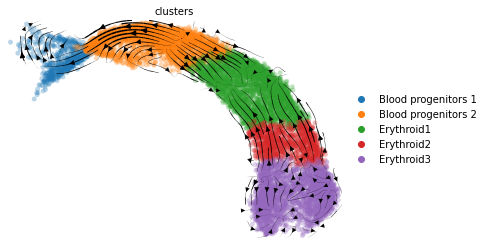

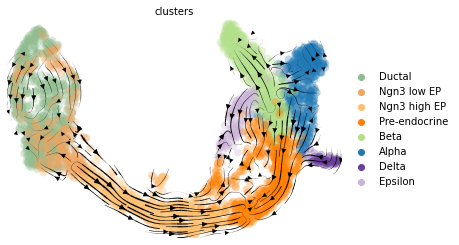

In [1]:
import os
os.chdir('..')
os.chdir('..')
import scvelo as scv
import scanpy as sc
import cell2fate as c2f
import pickle as pickle
from eval_utils import cross_boundary_correctness
from datetime import datetime
import pandas as pd
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt
import torch
import unitvelo as utv
method = 'Cell2fateDynamicalModel_250epochsbatchSize128_10samples'
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/'
datasets = ['Pancreas_with_cc',  'DentateGyrus' , 'MouseBoneMarrow', 'MouseErythroid', 'HumanBoneMarrow']
n_genes_list = np.array((2000, 3000))
n_counts_list = np.array((10, 20))

for i in range(len(n_genes_list)):
    for j in range(len(n_counts_list)):
        for k in (3,0,1,2,4):
            print(i)
            print(j)
            print(k)
            dataset = datasets[k]
            n_genes = n_genes_list[i]
            min_counts = n_counts_list[j]
            model_index = str(i) + '-' + str(j) + '-' + str(k)
            save_name = method + '_'
            if exists(save_dir + save_name + '_CBDC_fullBenchmark.csv'):
                tab = pd.read_csv(save_dir + save_name + '_CBDC_fullBenchmark.csv', index_col = 0)
                if model_index in tab.index:
                    continue
            adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
            adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**6, cluster_column = 'clusters',
                                            remove_clusters = [], min_shared_counts = min_counts, n_var_genes= n_genes)
            c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')    
            n_modules = c2f.utils.get_max_modules(adata)
            mod = c2f.Cell2fate_DynamicalModel(adata,
                                               n_modules = n_modules)   
            mod.train(max_epochs = 250, batch_size = 128)
            sample_kwarg = {"num_samples": 10, "batch_size" : adata.n_obs,
                 "use_gpu" : True, 'return_samples': False}
            adata = mod.export_posterior(adata, sample_kwargs = sample_kwarg)
            mod.compute_and_plot_total_velocity_scvelo(adata, save = False, delete = False)
            # Calculate performance metrics:
            file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
            ground_truth = pickle.load(file)
            metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
            cb_score = [np.mean(metrics['Cross-Boundary Direction Correctness (A->B)'][x])
                        for x in metrics['Cross-Boundary Direction Correctness (A->B)'].keys()]
            if exists(save_dir + save_name + '_CBDC_fullBenchmark.csv'):
                tab = pd.read_csv(save_dir + save_name + '_CBDC_fullBenchmark.csv', index_col = 0)
            else:
                c_names = ['CBDC']
                tab = pd.DataFrame(columns = c_names)
            tab.loc[model_index, 'CBDC'] = np.mean(cb_score)
            tab.to_csv(save_dir + save_name + '_CBDC_fullBenchmark.csv')
tab = pd.read_csv(save_dir + save_name + '_CBDC_fullBenchmark.csv', index_col = 0)
tab.loc['AVERAGE', 'CBDC'] = np.mean(tab['CBDC'])
tab.to_csv(save_dir + save_name + '_CBDC_fullBenchmark.csv')